In [1]:
import importlib
import numpy as np
from matplotlib import pyplot as plt
from scipy import special
from scipy.interpolate import interp1d
import plotly.io as pio
pio.renderers.default = "notebook"
import plotly.express as px
import plotly.graph_objects as go



import libs.MEVeS as S
importlib.reload(S)
import libs.AtomicConstants.Atom as AC
importlib.reload(AC)
import libs.Optimiser as Opt
importlib.reload(Opt)

<module 'libs.Optimiser' from 'c:\\users\\pmb18\\onedrive - imperial college london\\general\\meves_new\\libs\\Optimiser.py'>

In [2]:
def HermiteG(t, t0, FWHM, mode):
    """
    HG photon pulse creation
    """
    sigma = FWHM/1.6651092223153954
    H = special.hermite(mode, monic=False)
    unnormalised = H(np.sqrt(2)*(t - t0)/(sigma))*np.exp(-(t-t0)**2/(sigma**2)) #H(np.sqrt(2)*(t-t0)/sigma)*np.exp(-(t-t0)**2/(2* sigma**2))
    #norm = np.trapz(pow(unnormalised, 2), x=t) 
    #normalised = unnormalised/np.sqrt(norm)
    return unnormalised

def gaussian(t, t0, FWHM, A):
    """
    Gaussian function.  Returns value at specified time.
    t0 = peak time
    FWHM = full width at half maximum
    """
    return A*np.exp(-4*np.log(2)*np.power(t - t0, 2.) / (np.power(FWHM, 2.)))

kB = 1.38e-23
hbar = 1.05457182e-34
eps0 = 8.8541878128e-12
c = 299792458
 
def pV(T):
    """ Vapour pressure of Cs as a function of temperature (K) """
    # liquid phase, T>25C
    return pow(10, 8.22127 - 4006.048/T - 0.00060194*T - 0.19623*np.log10(T))
 
def Nv(T):
    """ Number density as a function of temperature (K) """
    return 133.323*pV(T)/(kB*T)

def optical_depth(atom, T, L):
    cross_section = pow(atom.reduced_dipoles[0], 2)*atom.angular_frequencies[0]/(atom.decay_rates[0]*eps0*hbar*c)
    OD = Nv(T)*L*cross_section
    return OD

In [3]:
def mode_matrix(number_of_modes, C):
    
    config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2},
                                                    "storage": {"n": 6, "L":0, "F" : 3}}}
    atom = AC.Cs(config)

    protocol = 'Raman'

    OD = 2000
    BW = 2*np.pi*1e9
    tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
    m = 500
    n = 50
    T = 0 #273.15 + 120  temperature set to 0
    vno = 1
    detuning = 2*np.pi*2*atom.deltaHF   #magic

    deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                        #for two photon resonance
    deltaC = detuning

    L = 0.075   #length cell in m

    t0 = 6*tau
    tend = 2*t0
    tbounds = np.array([0, tend])
    t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

    photon_pol = np.array([1, 0]) #should be normalised

    control_pol = np.array([1, 0]) #should be normalised

    Sinits = np.zeros((n, 1, 1, 1, 1, 1))
    
    effs = np.zeros((number_of_modes, number_of_modes))
    Alist = np.zeros(number_of_modes)

    for photon_a in range(0, number_of_modes):
        Einits = np.array(HermiteG(t, t0, tau, photon_a))
        norm = np.trapz(pow(Einits, 2), x=t) 
        Einits = Einits[:, None]/np.sqrt(norm) * photon_pol[None, :] # normalise to one photon
        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
        
        for control_a in range(0, number_of_modes):
            Control = np.array(HermiteG(t, t0, tau, control_a))
            norm = np.trapz(pow(Control, 2), x=t) 
            A = C * np.abs(sol.gamma +1j*detuning)/(np.sqrt(norm*OD*sol.gamma))
            Control = A*Control[:, None] * control_pol[None, :] # made so system now has Raman coupling strength C
            
            if photon_a == 0:
                Alist[control_a] = A
            
            sol.solve(sol.co_prop(Control))
            storage_eff = sol.storage_efficiency(sol.S, -1)
            effs[photon_a, control_a] = storage_eff
            # reset grids?
            sol.E[:] = 0
            sol.S[:] = 0
 
        del sol #?
    
    # Schmidt metric
    effs_normed = effs/(np.sum(effs, axis=0))
    Schmidt = 1/(np.sum(pow(effs_normed, 2), axis=0))

    # ratio metric
    if number_of_modes == 1:
        ratio = 0
    else:
        ratio = effs.diagonal()/np.sum(effs * ~np.eye(effs.shape[0],dtype=bool), axis=0)
    
    return Alist, effs, Schmidt, ratio 
            


In [4]:
def plot_matrix(Cs, effs,filename):
    # Create figure
    fig = go.Figure()
    x = np.arange(len(effs[0][0]))
    y = np.flip(np.arange(len(effs[0][0])))

    # Add traces, one for each slider step
    for i in range(len(Cs)):
        fig.add_trace(
            go.Heatmap(z = np.flip(effs[i], axis=0),
                       x = x,
                       y = y,
                       text = np.flip(effs[i], axis=0).round(3).astype(str),
                       texttemplate="%{text}",
                        textfont={"size":20},
                visible=False,
                name="C = " + str(Cs[i])))

    # Make first trace visible
    fig.data[0].visible = True

    # Create and add slider
    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)}],
            label = fig.data[i].name
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        active=0,
        pad={"t": 50},
        steps=steps
    )]

    fig.update_layout(
        sliders=sliders,
        xaxis_title="Control mode",
        yaxis_title="Signal mode",
        legend_title="Storage efficiency",
        xaxis = dict(tickmode = 'array', tickvals = x, ticktext = x, tickformat='%d'),
        yaxis = dict(tickmode = 'array', tickvals = y, ticktext = y, tickformat='%d'),
        width = 800,
        height = 800
    )
    
    fig.update_yaxes(autorange="reversed")

    fig.write_image(filename)
    fig.show()

In [5]:
def plot_linear(Cs, Schmidt, ylabel):
    # Create figure
    fig = go.Figure()
    x = np.arange(len(Schmidt[0]))
    
    # Add traces, one for each slider step
    for i in range(len(Cs)):
        fig.add_trace(
            go.Scatter(x = x,
                       y = Schmidt[i],
                visible=False,
                name="C = " + str(Cs[i])))

    # Make first trace visible
    fig.data[0].visible = True

    # Create and add slider
    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)}],
            label = fig.data[i].name
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        active=0,
        pad={"t": 50},
        steps=steps
    )]

    fig.update_layout(
        sliders=sliders,
        xaxis_title="Control mode",
        yaxis_title= ylabel,
        xaxis = dict(tickmode = 'array', tickvals = x, ticktext = x, tickformat='%d'),
    )
    
    fig.show()

In [6]:
def plot_matrix_max_scale(n_modes, data, max_scalebar,filename):
    labels_S = [f'{mode}' for mode in range(n_modes)]
    labels_C = [f'{mode}' for mode in range(n_modes)]
    fig = px.imshow(data, zmax = max_scalebar, text_auto = '.3f', facet_col_wrap=0, x = labels_S, y = labels_C)
    fig.update_xaxes(side="top")
    fig.update_layout(width = 800,height = 800, font=dict(size=16))
    fig.write_image(filename)
    fig.show(renderer = 'vscode')

In [7]:
number_of_modes = 5
C = 0.78
Alist, effs, Schmidt, ratio = mode_matrix(number_of_modes, C)
#print('Checkpoint mode matrix')
#plot_matrix_max_scale(number_of_modes,effs,0.45,'Plots/ModeSelectivity_5Modes_C0p78_MaxScale0p45.pdf')

In [8]:
plot_matrix_max_scale(number_of_modes,effs,0.45,'Plots/ModeSelectivity_5Modes_C0p48_MaxScale0p45.pdf')

In [14]:
number_of_modes = 5
C = 0.78
Alist, effs, Schmidt, ratio = mode_matrix(number_of_modes, C)
plot_matrix_max_scale(5,effs,0.45,'Plots/ModeSelectivity_5Modes_C0p78_MaxScale0p45.pdf')

In [7]:
number_of_modes = 5
C = 0.48
Alist, effs, Schmidt, ratio = mode_matrix(number_of_modes, C)

print(Alist)

plot_matrix([C], [effs],filename = 'Plots/ModeSelectivity_5Modes_C0p48.pdf')


# plot_linear([C], [Schmidt], "Schmidt number")

# plot_linear([C], [ratio], "Ratio")

[5.08622242e+09 3.59650236e+09 1.79825118e+09 7.34132970e+08
 2.59555201e+08]


In [14]:
number_of_modes = 5
C = 0.4
Alist, effs, Schmidt, ratio = mode_matrix(number_of_modes, C)

print(Alist)
plot_matrix([C], [effs])

# plot_linear([C], [Schmidt], "Schmidt number")

# plot_linear([C], [ratio], "Ratio")

[4.23851868e+09 2.99708530e+09 1.49854265e+09 6.11777475e+08
 2.16296001e+08]


In [18]:
number_of_modes = 5
C = 0.33
Alist, effs, Schmidt, ratio = mode_matrix(number_of_modes, C)

print(Alist)
plot_matrix([C], [effs])

# plot_linear([C], [Schmidt], "Schmidt number")

# plot_linear([C], [ratio], "Ratio")

[3.49677791e+09 2.47259537e+09 1.23629769e+09 5.04716417e+08
 1.78444201e+08]


In [10]:
number_of_modes = 10
C = 1
Alist_C1, effs_C1, Schmidt_C1, ratio_C1 = mode_matrix(number_of_modes, C)

print(Alist_C1)

plot_matrix([C], [effs_C1],filename = 'Plots/ModeSelectivity_10Modes_C1.pdf')

[1.05962967e+10 7.49271325e+09 3.74635663e+09 1.52944369e+09
 5.40740002e+08 1.70997003e+08 4.93625828e+07 1.31927052e+07
 3.29817629e+06 7.77387608e+05]


In [15]:
number_of_modes = 10
C = 1.5
Alist_C1p5, effs_C1p5, Schmidt_C1p5, ratio_C1p5 = mode_matrix(number_of_modes, C)

print(Alist_C1p5)

plot_matrix([C], [effs_C1p5],filename = 'Plots/ModeSelectivity_10Modes_C1p5.pdf')

[1.58944450e+10 1.12390699e+10 5.61953494e+09 2.29416553e+09
 8.11110002e+08 2.56495504e+08 7.40438742e+07 1.97890578e+07
 4.94726444e+06 1.16608141e+06]


In [16]:
number_of_modes = 10
C = 2
Alist_C2, effs_C2, Schmidt_C2, ratio_C2 = mode_matrix(number_of_modes, C)

print(Alist_C2)

plot_matrix([C], [effs_C2],filename = 'Plots/ModeSelectivity_10Modes_C2.pdf')

[2.11925934e+10 1.49854265e+10 7.49271325e+09 3.05888738e+09
 1.08148000e+09 3.41994005e+08 9.87251655e+07 2.63854103e+07
 6.59635259e+06 1.55477522e+06]


In [17]:
number_of_modes = 10
C = 0.5
Alist_C0p5, effs_C0p5, Schmidt_C0p5, ratio_C0p5 = mode_matrix(number_of_modes, C)

print(Alist_C0p5)

plot_matrix([C], [effs_C0p5],filename = 'Plots/ModeSelectivity_10Modes_C0p5.pdf')

[5.29814835e+09 3.74635663e+09 1.87317831e+09 7.64721844e+08
 2.70370001e+08 8.54985013e+07 2.46812914e+07 6.59635259e+06
 1.64908815e+06 3.88693804e+05]


## Optimise Control Shape

In [18]:
def mode_matrix_opt(number_of_modes, C):
    import MEVeS as S
    import Optimiser as Opt
    importlib.reload(Opt)
    importlib.reload(S)
    
    config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                        "storage": {"L": 0, "F" : 1}}}
    atom = AC.Rb87(config)

    protocol = 'Raman'

    OD = 2000
    BW = 2*np.pi*1e9
    tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
    m = 500
    n = 50
    T = 0 #273.15 + 120
    vno = 1
    detuning = 2*np.pi*6e9

    deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                        #for two photon resonance
    deltaC = detuning

    L = 0.075

    t0 = 6*tau
    tend = 2*t0
    tbounds = np.array([0, tend])

    t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

    photon_pol = np.array([1, 0]) #should be normalised

    control_pol = np.array([1, 0]) #should be normalised

    Sinits = np.zeros((n, 1, 1, 1, 1, 1))
    
    effs = np.zeros((number_of_modes, number_of_modes))
    Alist = np.zeros(number_of_modes)
    
    for control_a in range(0, number_of_modes):
        Einits = np.array(HermiteG(t, t0, tau, control_a))
        norm = np.trapz(pow(Einits, 2), x=t) 
        Einits = Einits[:, None]/np.sqrt(norm) * photon_pol[None, :] # normalise to one photon
        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
        
        # optimise diagonal
        Control = np.array(HermiteG(t, t0, tau, control_a))
        norm = np.trapz(pow(Control, 2), x=t) 
        A = C * np.abs(sol.gamma +1j*detuning)/(np.sqrt(norm*OD*sol.gamma))
        Control = A*Control[:, None] * control_pol[None, :] # made so system now has Raman coupling strength C

        Ec = pow(A, 2)*norm # control pulse energy
        max_energies = [Ec]

        opt = Opt.optimiser(sol, method='RK4', _complex=True, verbose=False, live_plot=False)
        step_size = 2000
        tol = 1e-3
        eff, Control_opts, count = opt.Krotov(opt.backward_retrieval_opt_storage, [Control], step_size, tol,
                                adaptive_step_size=False, max_energies=max_energies)
        
        plt.plot(t, np.abs(Control[:, 0]))
        plt.plot(t, np.abs(Control_opts[0][:, 0]))
        plt.show()
        
#         plt.plot(t, np.angle(Control[:, 0]))
#         plt.plot(t, np.angle(Control_opts[0][:, 0]))
#         plt.show()
        
        for photon_a in range(0, number_of_modes):
            
            Einits = np.array(HermiteG(t, t0, tau, photon_a))
            norm = np.trapz(pow(Einits, 2), x=t) 
            Einits = Einits[:, None]/np.sqrt(norm) * photon_pol[None, :] # normalise to one photon
            sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
            
            if photon_a == 0:
                Alist[control_a] = max(np.abs(Control_opts[0]).flatten())
            
            sol.solve(sol.co_prop(Control_opts[0]))
            storage_eff = sol.storage_efficiency(sol.S, -1)
            effs[photon_a, control_a] = storage_eff
            
        del sol #?
    
    # Schmidt metric
    effs_normed = effs/(np.sum(effs, axis=0))
    Schmidt = 1/(np.sum(pow(effs_normed, 2), axis=0))
    
    # ratio metric
    if number_of_modes == 1:
        ratio = 0
    else:
        ratio = effs.diagonal()/np.sum(effs * ~np.eye(effs.shape[0],dtype=bool), axis=0)
    
    return Alist, effs, Schmidt, ratio 

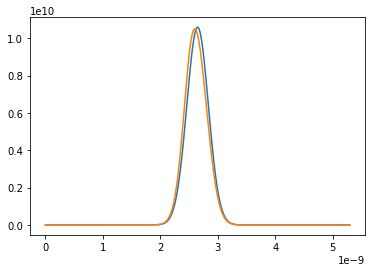

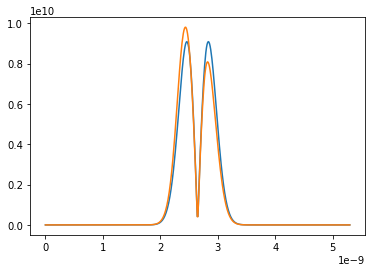

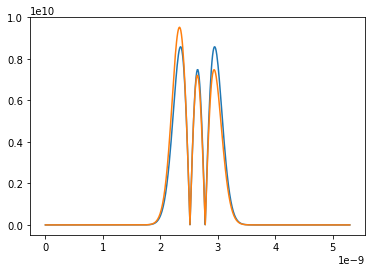

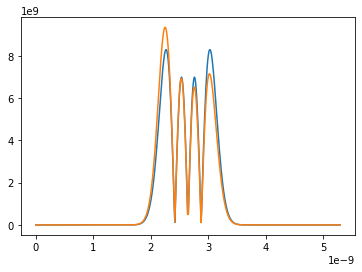

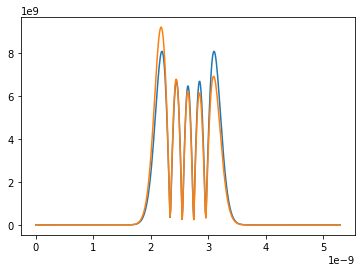

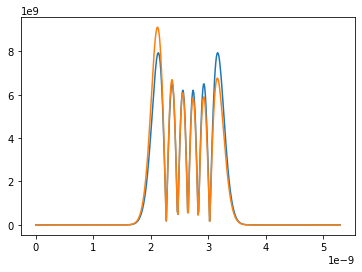

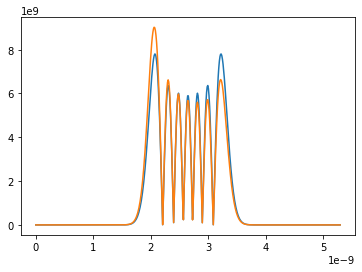

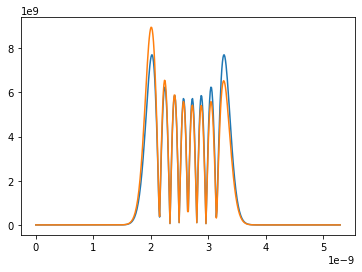

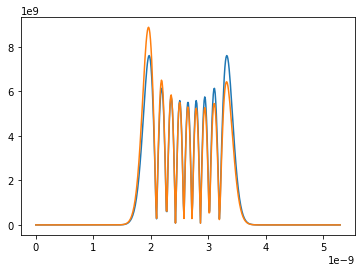

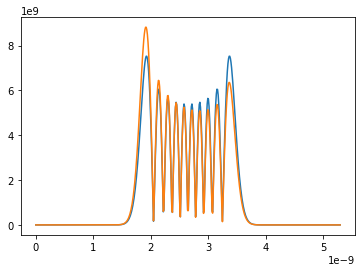

[1.05962967e+10 7.49271325e+09 3.74635663e+09 1.52944369e+09
 5.40740002e+08 1.70997003e+08 4.93625828e+07 1.31927052e+07
 3.29817629e+06 7.77387608e+05]


In [19]:
number_of_modes = 10
C = 1
Alist_C1_opt, effs_C1_opt, Schmidt_C1_opt, ratio_C1_opt = mode_matrix_opt(number_of_modes, C)

print(Alist)
plot_matrix([C], [effs_C1_opt],filename = 'Plots/ModeSelectivity_10Modes_C1_opt.pdf')



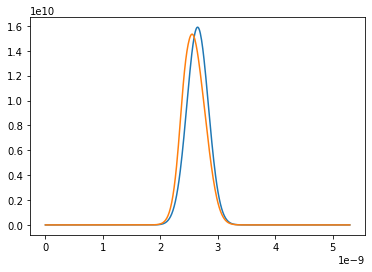

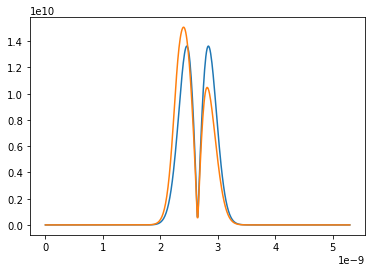

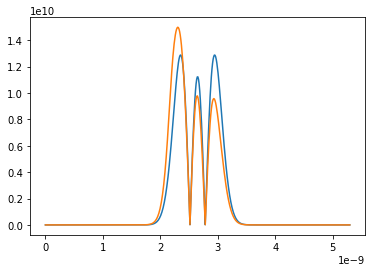

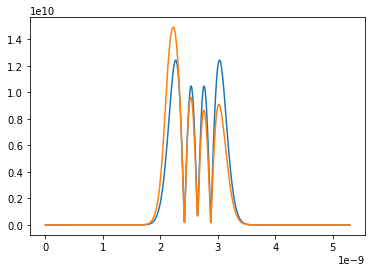

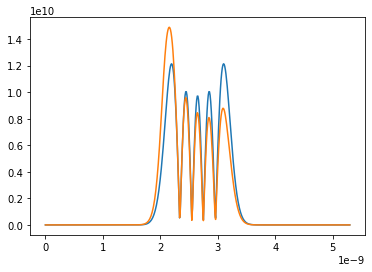

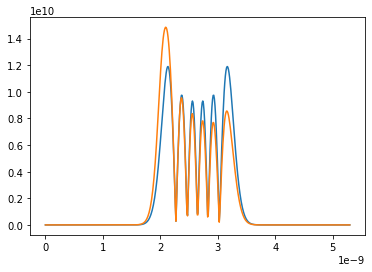

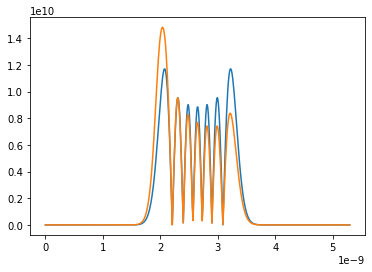

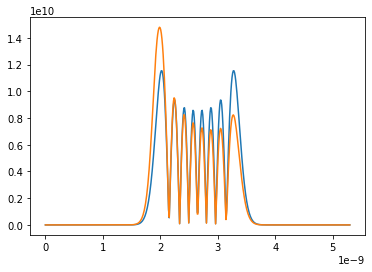

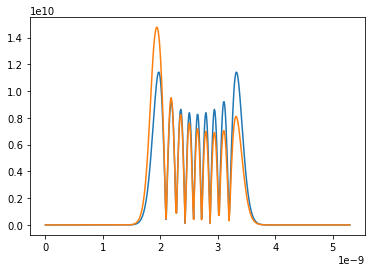

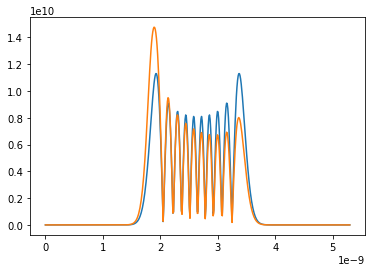

[1.05962967e+10 7.49271325e+09 3.74635663e+09 1.52944369e+09
 5.40740002e+08 1.70997003e+08 4.93625828e+07 1.31927052e+07
 3.29817629e+06 7.77387608e+05]


In [23]:
number_of_modes = 10
C = 1.5
Alist_C1p5_opt, effs_C1p5_opt, Schmidt_C1p5_opt, ratio_C1p5_opt = mode_matrix_opt(number_of_modes, C)

print(Alist)
plot_matrix([C], [effs_C1p5_opt],filename = 'Plots/ModeSelectivity_10Modes_C1p5_opt.pdf')

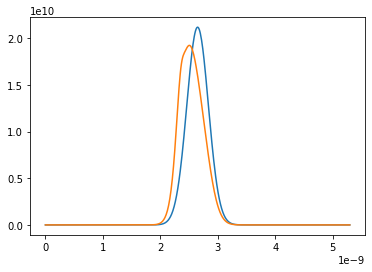

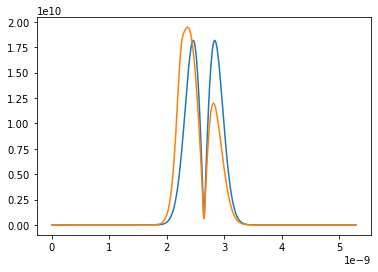

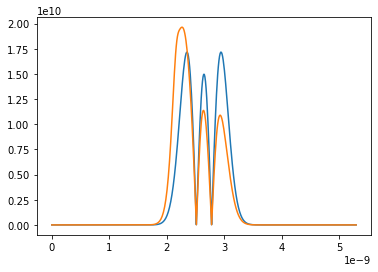

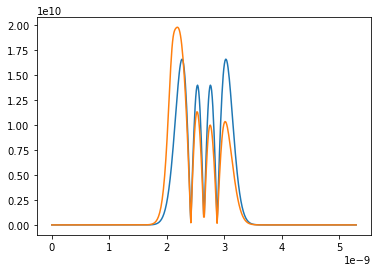

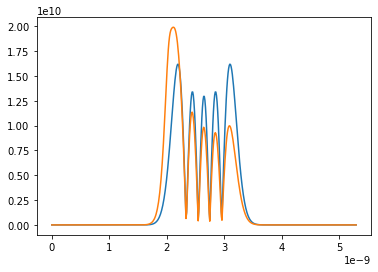

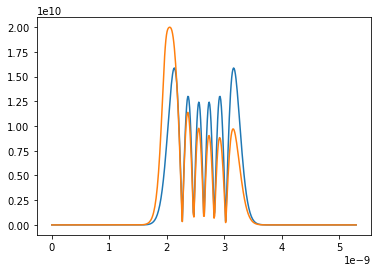

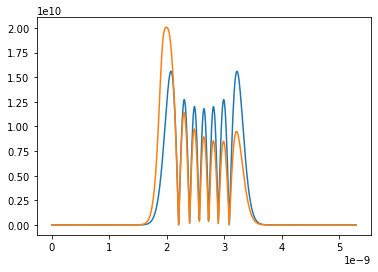

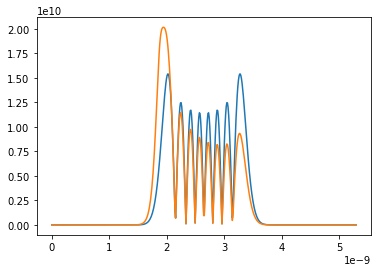

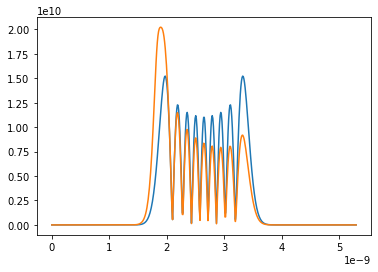

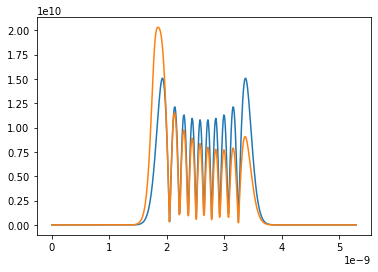

[1.05962967e+10 7.49271325e+09 3.74635663e+09 1.52944369e+09
 5.40740002e+08 1.70997003e+08 4.93625828e+07 1.31927052e+07
 3.29817629e+06 7.77387608e+05]


In [24]:
number_of_modes = 10
C = 2
Alist_C2_opt, effs_C2_opt, Schmidt_C2_opt, ratio_C2_opt = mode_matrix_opt(number_of_modes, C)

print(Alist)
plot_matrix([C], [effs_C2_opt],filename = 'Plots/ModeSelectivity_10Modes_C2_opt.pdf')

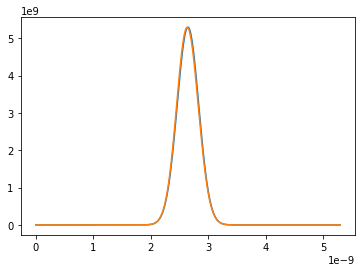

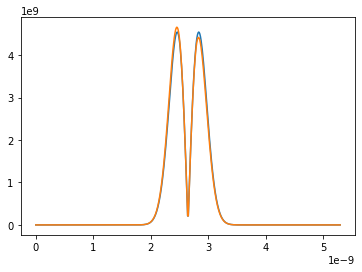

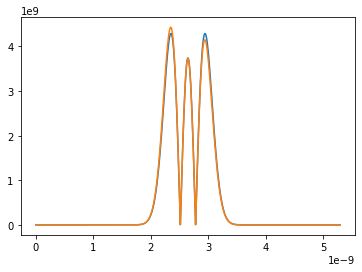

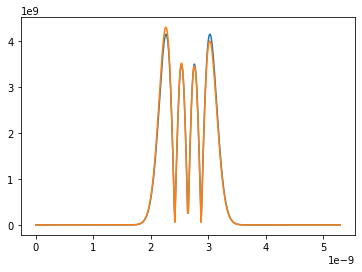

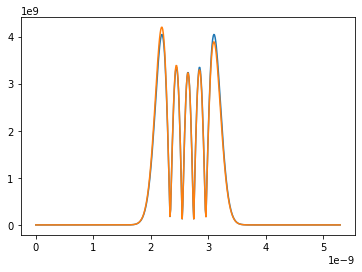

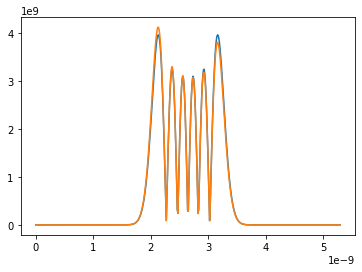

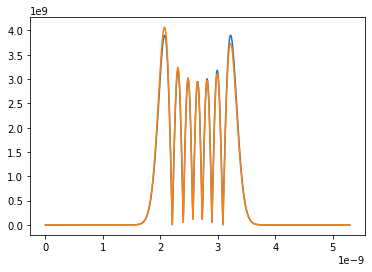

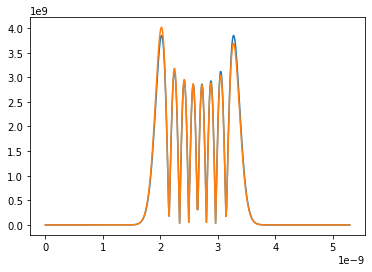

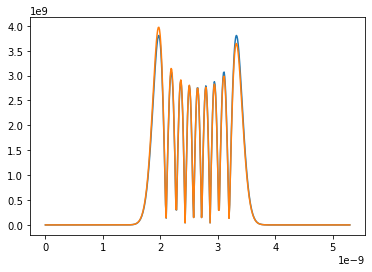

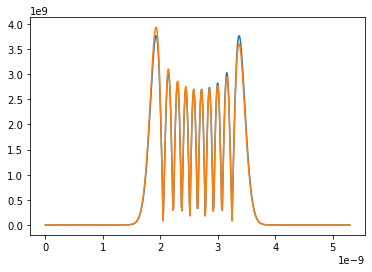

[1.05962967e+10 7.49271325e+09 3.74635663e+09 1.52944369e+09
 5.40740002e+08 1.70997003e+08 4.93625828e+07 1.31927052e+07
 3.29817629e+06 7.77387608e+05]


In [25]:
number_of_modes = 10
C = 0.5
Alist_C0p5_opt, effs_C0p5_opt, Schmidt_C0p5_opt, ratio_C0p5_opt = mode_matrix_opt(number_of_modes, C)

print(Alist)
plot_matrix([C], [effs_C0p5_opt],filename = 'Plots/ModeSelectivity_10Modes_C0p5_opt.pdf')

In [46]:
def plot_matrix_max_scale(n_modes, data, max_scalebar,filename):
    labels_S = [f'{mode}' for mode in range(n_modes)]
    labels_C = [f'{mode}' for mode in range(n_modes)]
    fig = px.imshow(data, zmax = max_scalebar, text_auto = '.3f', facet_col_wrap=0, x = labels_S, y = labels_C)
    fig.update_xaxes(side="top")
    fig.update_layout(width = 800,height = 800, font=dict(size=16))
    fig.write_image(filename)
    fig.show(renderer = 'vscode')

In [49]:
plot_matrix_max_scale(10, effs_C2_opt,max_scalebar=1,filename = 'Plots/ModeSelectivity_10Modes_C2_opt_maxscale1.pdf')
plot_matrix_max_scale(10, effs_C1p5_opt,max_scalebar=1,filename = 'Plots/ModeSelectivity_10Modes_C1p5_opt_maxscale1.pdf')
plot_matrix_max_scale(10, effs_C1_opt,max_scalebar=1,filename = 'Plots/ModeSelectivity_10Modes_C1_opt_maxscale1.pdf')
plot_matrix_max_scale(10, effs_C0p5_opt,max_scalebar=1,filename = 'Plots/ModeSelectivity_10Modes_C0p5_opt_maxscale1.pdf')

plot_matrix_max_scale(10, effs_C2,max_scalebar=1,filename = 'Plots/ModeSelectivity_10Modes_C2_maxscale1.pdf')
plot_matrix_max_scale(10, effs_C1p5,max_scalebar=1,filename = 'Plots/ModeSelectivity_10Modes_C1p5_maxscale1.pdf')
plot_matrix_max_scale(10, effs_C1,max_scalebar=1,filename = 'Plots/ModeSelectivity_10Modes_C1_maxscale1.pdf')
plot_matrix_max_scale(10, effs_C0p5,max_scalebar=1,filename = 'Plots/ModeSelectivity_10Modes_C0p5_maxscale1.pdf')


In [40]:
#effs[photon_a, control_a] = storage_eff
effs_C2_opt[1,0]


0.20266570863641759

## ORCA

In [65]:
def mode_matrix_ORCA(number_of_modes, C,L):
    
    config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                        "storage": {"L": 0, "F" : 1}}}
    atom = AC.Rb87(config)

    protocol = 'ORCA'

    OD = 2000
    BW = 2*np.pi*1e9
    tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
    m = 500
    n = 50
    T = 0 #273.15 + 120
    vno = 1
    detuning = 2*np.pi*6e9

    deltaS = -detuning #definition of detuning means that signal field and control field should be negative of each other
                        #for two photon resonance
    deltaC = detuning

    #L = 0.05

    t0 = 6*tau
    tend = 2*t0
    tbounds = np.array([0, tend])

    t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

    photon_pol = np.array([1, 0]) #should be normalised

    control_pol = np.array([1, 0]) #should be normalised

    Sinits = np.zeros((n, 1, 1, 1, 1, 1))
    
    effs = np.zeros((number_of_modes, number_of_modes))
    Alist = np.zeros(number_of_modes)
    
    for photon_a in range(0, number_of_modes):
        Einits = np.array(HermiteG(t, t0, tau, photon_a))
        norm = np.trapz(pow(Einits, 2), x=t) 
        Einits = Einits[:, None]/np.sqrt(norm) * photon_pol[None, :] # normalise to one photon
        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
        
        for control_a in range(0, number_of_modes):
            Control = np.array(HermiteG(t, t0, tau, control_a))
            norm = np.trapz(pow(Control, 2), x=t) 
            A = C * np.abs(sol.gamma +1j*detuning)/(np.sqrt(norm*OD*sol.gamma))
            Control = A*Control[:, None] * control_pol[None, :] # made so system now has Raman coupling strength C
            
            if photon_a == 0:
                Alist[control_a] = A
            
            sol.solve(sol.counter_prop(Control))
            storage_eff = sol.storage_efficiency(sol.S, -1)
            effs[photon_a, control_a] = storage_eff
            # reset grids?
            sol.E[:] = 0
            sol.S[:] = 0
            
        del sol #?
    
    # Schmidt metric
    effs_normed = effs/(np.sum(effs, axis=0))
    Schmidt = 1/(np.sum(pow(effs_normed, 2), axis=0))
    
    # ratio metric
    if number_of_modes == 1:
        ratio = 0
    else:
        ratio = effs.diagonal()/np.sum(effs * ~np.eye(effs.shape[0],dtype=bool), axis=0)
    
    return Alist, effs, Schmidt, ratio 
            


In [66]:
number_of_modes = 5
C = 1
L=0.05
Alist, effs, Schmidt, ratio = mode_matrix_ORCA(number_of_modes, C,L)

print(Alist)
plot_matrix([C], [effs],filename= 'Plots/ModeSelectivity_ORCA_5Modes_C1_L5cm.pdf')

[1.05962967e+10 7.49271325e+09 3.74635663e+09 1.52944369e+09
 5.40740002e+08]


## Frequency Modes

In [77]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}, "dressing": {"n" : 8, "L": 3, "J" : 7/2}}}
atom = AC.Rb87(config)

kB = 1.38e-23 
hbar = 1.05457182e-34
eps0 = 8.8541878128e-12
c = 299792458

def pV(T):
    """ Vapour pressure of Cs as a function of temperature (K) """
    # liquid phase, T>25C
    return pow(10, 8.22127 - 4006.048/T - 0.00060194*T - 0.19623*np.log10(T))

def Nv(T):
    """ Number density as a function of temperature (K) """
    return 133.323*pV(T)/(kB*T)
def optical_depth(atom, T, L):
    cross_section = pow(atom.reduced_dipoles[0], 2)*atom.angular_frequencies[0]/(atom.decay_rates[0]*eps0*hbar*c)
    OD = Nv(T)*L*cross_section
    return OD

def effective_optical_depth(atom, OD, T):
    width = np.sqrt(kB*T/(atom.mass*pow(c, 2)))*atom.angular_frequencies[0]
    ODdash = OD*atom.decay_rates[0]/(2*width) * np.sqrt(np.pi*np.log(2))
    return ODdash


T = 273.15 + 110
L = 0.075
print( optical_depth(atom, T, L)/2 )

293244.34419699654


### Efficiency vs detuning of signal

In [92]:
protocol = 'TORCAP'

OD_fudge_factor = 0.3

Omega1 = 2*np.pi*0.04*1e10
Omega2 = 2*np.pi*0.05*1e10

T = 273.15 + 120
L = 0.075
OD = OD_fudge_factor*optical_depth(atom, T, L)/2


BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 2000
n = 50

vno = 30
detuning = -2*np.pi*6e9
#definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance


t0 = 6*tau
tend = 5e-9
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

BWc = 2*np.pi*1e9
tauc = 2*np.log(2)/(np.pi*(BWc/(2*np.pi)))
control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

tr_plus = 1e-9 - 750e-12
tr = 750e-12 + tr_plus
toffset = -100e-12

window_size = 800e-12
readin_window = [t0-window_size/2, t0+window_size/2]
#readout_window = [t0+tr-400e-12*gamma, t0+tr+100e-12*gamma]
readout_window = [t0+660e-12-window_size/2+tr_plus, t0+660e-12+window_size/2+tr_plus]
readin_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readin_window[0])),
                      min(range(len(t)), key=lambda i:abs(t[i]-readin_window[1]))]
readout_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readout_window[0])),
                      min(range(len(t)), key=lambda i:abs(t[i]-readout_window[1]))]


freq_list = np.linspace(-3,3,21)
readin_eff_list = np.zeros(len(freq_list))
total_eff_list = np.zeros(len(freq_list))
for i, freq in enumerate(freq_list):


    deltaS = detuning +freq*BW
    deltaC = -detuning

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, 0], OD, L, n, m, tbounds, T, vno)



    Control1s = (S.gaussian(t, t0+toffset, tauc, Omega1))[:, None] * control_pol[None, :]
    Control1r = (S.gaussian(t, t0+tr+toffset, tauc, Omega2))[:, None] * control_pol[None, :]

    Control1 = sol.counter_prop( Control1s + Control1r, zdef=0.5, field=0)

    Control=Control1



    sol.solve(Control, method='RK4-Ralston')

    norm = np.trapz( pow(np.abs(sol.E[:, 0, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                        x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )
        
    stored = 1-np.trapz( pow(np.abs(sol.E[:, -1, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                    x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )/norm

    total = np.trapz( pow(np.abs(sol.E[:, -1, 0])[readout_window_index[0]:readout_window_index[1]], 2), 
                    x=sol.tpoints[readout_window_index[0]:readout_window_index[1]] )

    retrieved=total/stored
    readin_eff_list[i] = (stored)
    total_eff_list[i] = (total)


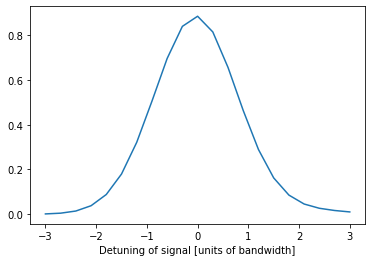

In [93]:
plt.plot(freq_list,readin_eff_list)
#plt.plot(freq_list,total_eff_list)
plt.xlabel('Detuning of signal [units of bandwidth]')
plt.show()

### Efficiency vs detuning of signal and control

In [123]:
protocol = 'TORCAP'

OD_fudge_factor = 0.3

Omega1 = 2*np.pi*0.04*1e10
Omega2 = 2*np.pi*0.05*1e10

T = 273.15 + 120
L = 0.075
OD = OD_fudge_factor*optical_depth(atom, T, L)/2


BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50

vno = 30
detuning = -2*np.pi*15e9
#definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance


t0 = 6*tau
tend = 5e-9
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

BWc = 2*np.pi*1e9
tauc = 2*np.log(2)/(np.pi*(BWc/(2*np.pi)))
control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

tr_plus = 1e-9 - 750e-12
tr = 750e-12 + tr_plus
toffset = -100e-12

window_size = 800e-12
readin_window = [t0-window_size/2, t0+window_size/2]
#readout_window = [t0+tr-400e-12*gamma, t0+tr+100e-12*gamma]
readout_window = [t0+660e-12-window_size/2+tr_plus, t0+660e-12+window_size/2+tr_plus]
readin_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readin_window[0])),
                      min(range(len(t)), key=lambda i:abs(t[i]-readin_window[1]))]
readout_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readout_window[0])),
                      min(range(len(t)), key=lambda i:abs(t[i]-readout_window[1]))]


freq_list = np.linspace(-10,10,21)
readin_eff_list = np.zeros((len(freq_list),len(freq_list)))
total_eff_list = np.zeros((len(freq_list),len(freq_list)))

for i, freq in enumerate(freq_list):


    deltaS = detuning +freq*BW

    for j, freq in enumerate(freq_list):
        deltaC = -detuning +freq*BW

        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, 0], OD, L, n, m, tbounds, T, vno)



        Control1s = (S.gaussian(t, t0+toffset, tauc, Omega1))[:, None] * control_pol[None, :]
        Control1r = (S.gaussian(t, t0+tr+toffset, tauc, Omega2))[:, None] * control_pol[None, :]

        Control1 = sol.counter_prop( Control1s + Control1r, zdef=0.5, field=0)

        Control=Control1



        sol.solve(Control, method='RK4-Ralston')

        norm = np.trapz( pow(np.abs(sol.E[:, 0, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                            x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )
            
        stored = 1-np.trapz( pow(np.abs(sol.E[:, -1, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                        x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )/norm

        total = np.trapz( pow(np.abs(sol.E[:, -1, 0])[readout_window_index[0]:readout_window_index[1]], 2), 
                        x=sol.tpoints[readout_window_index[0]:readout_window_index[1]] )

        retrieved=total/stored
        readin_eff_list[i,j] = (stored)
        total_eff_list[i,j] = (total)


In [113]:
print(readin_eff_list)

[[-7.98599921e-06 -5.44196790e-06 -3.76199439e-06 -2.45480709e-06
  -1.03874205e-06  2.63640708e-06  5.22829622e-04  5.16693466e-02
   2.27356291e-01]
 [-9.57143325e-06 -6.45283582e-06 -4.28788922e-06 -2.26670723e-06
   2.22282283e-06  5.91402126e-04  5.90898210e-02  2.59451337e-01
   5.08539049e-02]
 [-1.16907386e-05 -7.71310262e-06 -4.55981275e-06  1.15202999e-06
   6.70943532e-04  6.80771035e-02  2.98348313e-01  5.80798504e-02
   4.90197367e-04]
 [-1.45816961e-05 -9.04810280e-06 -1.30277131e-06  7.61837180e-04
   7.90242076e-02  3.45864864e-01  6.68078565e-02  5.51798255e-04
   1.32871013e-07]
 [-1.84457300e-05 -6.81092808e-06  8.62297745e-04  9.23903785e-02
   4.04285182e-01  7.74031875e-02  6.22634251e-04 -4.22307739e-07
  -2.90946198e-06]
 [-1.95567644e-05  9.65494557e-04  1.08631082e-01  4.76304604e-01
   9.02832501e-02  7.02891030e-04 -1.33398211e-06 -4.13714006e-06
  -3.97847584e-06]
 [ 1.05446382e-03  1.27954910e-01  5.64567057e-01  1.05840474e-01
   7.91160074e-04 -2.8405924

Text(0, 0.5, 'Signal detuning')

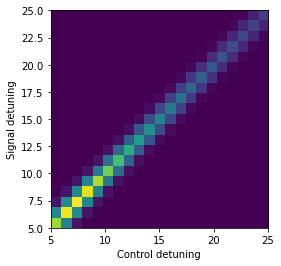

In [124]:
freq_list = np.linspace(-10,10,21)
deltaS = -(detuning +freq_list*BW) / (2*np.pi * 1e9)
deltaC = (-detuning +freq_list*BW)/ (2*np.pi * 1e9)

plt.imshow(readin_eff_list, extent=[min(deltaS),max(deltaS),min(deltaC),max(deltaC)])
plt.xlabel('Control detuning')
plt.ylabel('Signal detuning')


## Schmidt number

In [130]:
plot_linear([2], [Schmidt_C0p5_opt], "Schmidt number")
effs_C0p5_opt[0,:]

array([2.20716169e-01, 2.55809173e-05, 5.56914304e-08, 1.83880777e-08,
       5.34577176e-11, 7.24802823e-11, 3.05523187e-13, 4.71012615e-13,
       2.37755212e-15, 3.85907220e-15])

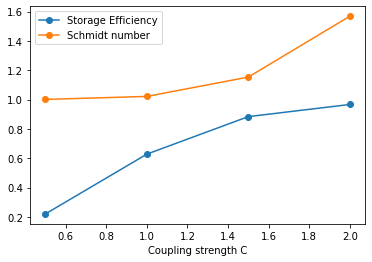

In [135]:
C = [0.5,1,1.5,2]
effs_opt = [effs_C0p5_opt[0,0],effs_C1_opt[0,0],effs_C1p5_opt[0,0],effs_C2_opt[0,0]]
Schmidt = [Schmidt_C0p5_opt[0],Schmidt_C1_opt[0],Schmidt_C1p5_opt[0],Schmidt_C2_opt[0]]

plt.plot(C,effs_opt,'o-',label='Storage Efficiency')
plt.plot(C,Schmidt,'o-',label='Schmidt number')
plt.xlabel('Coupling strength C')
plt.legend()
plt.savefig('Plots/SchmidtEffsVsC.pdf')
plt.show()

